In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from plotly import graph_objects as go
from PCAfold import reduction
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 14})


Load the data.

In [2]:
folder = 'data_and_preprocessing_mixfrac_641_dissrate_321_clustered_CH4_gri12/'
prefix = 'mixfrac_641_dissrate_321_clustered_'

state_space = np.loadtxt(folder+prefix+'STEADY-flamelet-CH4-gri12-state-space.csv', delimiter = ',')
state_space_sources = np.loadtxt(folder+prefix+'STEADY-flamelet-CH4-gri12-state-space-sources.csv', delimiter = ',')
state_space_names_raw = pd.read_csv(folder+prefix+'STEADY-flamelet-CH4-gri12-state-space-names.csv',header=None)
state_space_names = np.array([x for x in state_space_names_raw[0]])
STEADY_mf = np.loadtxt(folder+prefix+'STEADY-flamelet-CH4-gri12-mixture-fraction.csv', delimiter=',')
STEADY_chi = np.loadtxt(folder+prefix+'STEADY-flamelet-CH4-gri12-dissipation-rates.csv', delimiter=',')


Train the PCA transformation. We will subsample the data from the resulting manifold.

In [3]:
##### 2D example #####
ncomp = 2
scaling = 'none'
selected_variables = [15, 6, 4, 16, 23, 1, 25, 5, 3, 18, 7, 2, 30, 29, 24, 17, 28, 11, 8, 10, 9, 19, 22, 12] # variables for subset PCA

##### 3D example #####
# ncomp = 3
# scaling = '-1to1'
# selected_variables = [16, 15, 4, 10, 17] # variables for subset PCA

print('selected variables:', np.array(state_space_names)[selected_variables])

subset_pca = reduction.PCA(state_space[:,selected_variables], scaling=scaling, n_components=ncomp)
subset_PCs = subset_pca.transform(state_space[:,selected_variables])
subset_PC_sources = subset_pca.transform(state_space_sources[:,selected_variables], nocenter=True)
print('original data shape:', subset_PCs.shape)


selected variables: ['CO' 'H2O' 'O2' 'CO2' 'C2H2' 'H2' 'C2H4' 'OH' 'O' 'CH2O' 'HO2' 'H'
 'HCCOH' 'CH2CO' 'C2H3' 'HCO' 'HCCO' 'CH2' 'H2O2' 'CH' 'C' 'CH2OH' 'C2H'
 'CH2(S)']
original data shape: (205761, 2)


Plot the manifold before subsampling

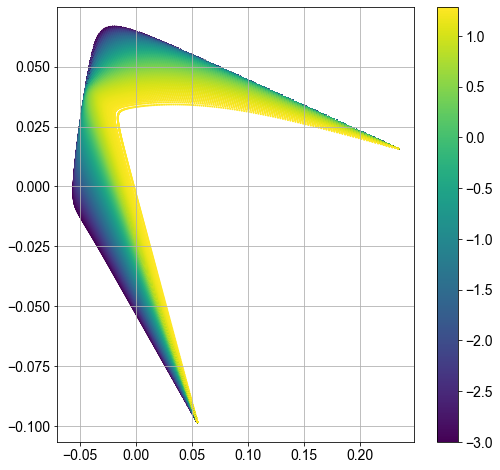

In [4]:
if ncomp==2:
    plt.scatter(subset_PCs[:,0], subset_PCs[:,1], c=np.log10(STEADY_chi[:]), s=1)
    plt.colorbar()
    plt.grid()
    plt.show()
    
if ncomp==3:
    # for coloring by log scale source term...
    threshold = 1.e-10
    pcs = subset_PC_sources.copy()
    pcs[np.abs(pcs)<threshold] = threshold

    fig = go.Figure(data=[go.Scatter3d(
        x = subset_PCs[:,0],
        y = subset_PCs[:,1],
        z = subset_PCs[:,2],
        mode='markers',
        marker=dict(
            size=3,
            color=np.log10(STEADY_chi[:]), # color by chi
    #         color=STEADY_mf[:], # color by z
    #         color=np.log10(np.abs(pcs))[:,2], # color by log abs source term
            colorscale='Viridis',
            colorbar=dict(thickness=20)
           )
        ),])
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0.5,
            dtick = 10
        )
    )
    fig.update_layout(
        scene=dict(
            xaxis=dict(showticklabels=False, showaxeslabels = False),
            yaxis=dict(showticklabels=False,showaxeslabels = False),
            zaxis=dict(showticklabels=False,showaxeslabels = False),
        )
    )
    fig.show()


Subsample the manifold for training the regression model. 

Points will be removed whenever the spacing (on the manifold) in the dissipation rate direction is smaller than the spacing in mixture fraction * zspacing_percentage_threshold. The parameter zspacing_percentage_threshold can be tuned to remove more/fewer points. 

In [5]:
zspacing_percentage_threshold = 0.8

uniquez = np.unique(STEADY_mf) # unique values of mixture fraction (z)
uniquechi = np.unique(STEADY_chi) # unique values of dissipation rate (chi)

idxdelete = [] # these will be the indices of observations to remove

# remove any observations that have smaller spacing in chi than z (on average)...
for iz in range(1,uniquez.size-1): # start with interior points
    izl_PCs = subset_PCs[STEADY_mf==uniquez[iz-1], :] # z to left
    iz0_PCs = subset_PCs[STEADY_mf==uniquez[iz], :] # z value
    izr_PCs = subset_PCs[STEADY_mf==uniquez[iz+1], :] # z to right
    
    for ichi in range(1,len(uniquechi)): # loop through chi indices
        if ichi==1: # if first index in chi, compute the average spacing in z
            icompare = 0
            dz_l = distance.euclidean(izl_PCs[icompare,:], iz0_PCs[icompare,:])
            dz_r = distance.euclidean(izr_PCs[icompare,:], iz0_PCs[icompare,:])
            avgdz = np.mean([dz_l, dz_r])
        
        dchi = distance.euclidean(iz0_PCs[icompare,:], iz0_PCs[ichi,:]) # compute distance in chi

        if zspacing_percentage_threshold*avgdz>dchi: # if spacing in z larger than in chi, want to delete that chi observation
            idxdelete.append(iz*len(uniquechi)+ichi)
        else: # otherwise, spacing is okay so reset the spacing in z at the next acceptable chi
            icompare = ichi
            dz_l = distance.euclidean(izl_PCs[icompare,:], iz0_PCs[icompare,:])
            dz_r = distance.euclidean(izr_PCs[icompare,:], iz0_PCs[icompare,:])
            avgdz = np.mean([dz_l, dz_r])

# also want to remove duplicate observations at boundaries z=0 and z=1...
for ichi in range(1,len(uniquechi)):
    idxdelete.append(ichi) # iz = 0
    idxdelete.append((len(uniquez)-1)*len(uniquechi)+ichi) # iz = len(uniquez)-1

print('number of observations to delete:',len(idxdelete))


number of observations to delete: 118625


Compute the new PCs based on the subsampled manifold (for training the regression model).

In [6]:
subset_PCs_new = np.delete(subset_PCs, idxdelete, axis=0)
subset_PC_sources_new = np.delete(subset_PC_sources, idxdelete, axis=0)
STEADY_mf_new = np.delete(STEADY_mf, idxdelete, axis=0)
STEADY_chi_new = np.delete(STEADY_chi, idxdelete, axis=0)
print('new data shape:', subset_PCs_new.shape)


new data shape: (87136, 2)


Plot the new manifold.

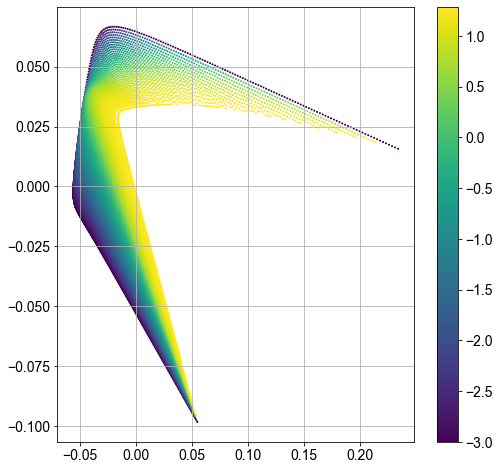

In [7]:
if ncomp==2:
    plt.scatter(subset_PCs_new[:,0], subset_PCs_new[:,1], c=np.log10(STEADY_chi_new[:]), s=1)
    plt.colorbar()
    plt.grid()
    plt.show()

if ncomp==3:
    # for coloring by log scale source term...
    threshold = 1.e-10
    pcs = subset_PC_sources_new.copy()
    pcs[np.abs(pcs)<threshold] = threshold

    fig = go.Figure(data=[go.Scatter3d(
        x = subset_PCs_new[:,0],
        y = subset_PCs_new[:,1],
        z = subset_PCs_new[:,2],
        mode='markers',
        marker=dict(
            size=3,
            color=np.log10(STEADY_chi_new[:]), # color by chi
    #         color=STEADY_mf_new[:], # color by z
    #         color=np.log10(np.abs(pcs))[:,2], # color by log abs source term
            colorscale='Viridis',
            colorbar=dict(thickness=20)
           )
        ),])
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0.5,
            dtick = 10
        )
    )
    fig.update_layout(
        scene=dict(
            xaxis=dict(showticklabels=False, showaxeslabels = False),
            yaxis=dict(showticklabels=False,showaxeslabels = False),
            zaxis=dict(showticklabels=False,showaxeslabels = False),
        )
    )
    fig.show()


Visualize the source terms over mixture fraction at a particular dissipation rate to see which points will be used in building the regression models. Uncomment the boottom half to see the original data.

modified data...
number of available dissipation rates: 321 , specified index 120
dissipation rate at specified index: 0.040426070141946824


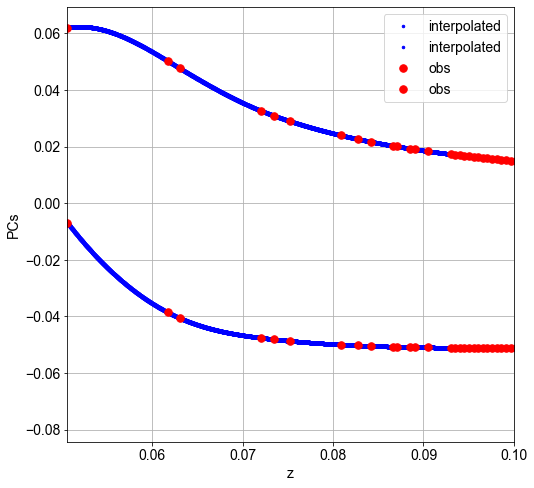

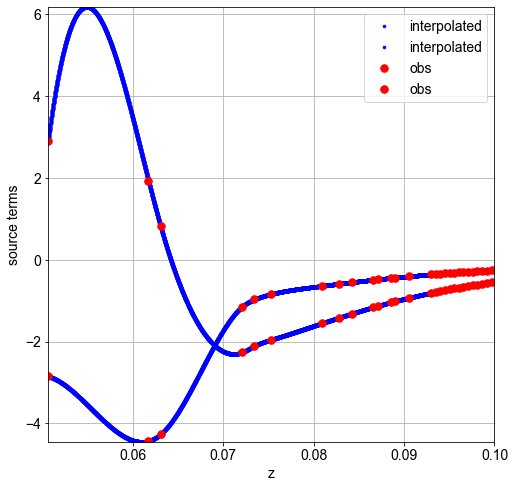

In [8]:
##################### Subsampled data #####################
### (but the interpolant is still built over the entire dataset)

chist_initial_idx = 120 # index will grab value at


print('modified data...')
unique_chi = np.unique(STEADY_chi_new)
print('number of available dissipation rates:', len(unique_chi), ', specified index', chist_initial_idx)
print('dissipation rate at specified index:',unique_chi[chist_initial_idx])

queryidx = np.argwhere(STEADY_chi_new==unique_chi[chist_initial_idx])[:,0]

ic = subset_PCs_new[queryidx,:] # define corresponding initial condition
zgrid = STEADY_mf_new[queryidx] # use the same mixture fraction grid as for generating the data
srcobs = subset_PC_sources_new[queryidx,:]

zorder = np.argsort(zgrid)
zgrid = zgrid[zorder]
ic = ic[zorder,:]
srcobs = srcobs[zorder,:]

spl = CubicSpline(zgrid, ic)
srcspl = CubicSpline(zgrid, srcobs)


npts = 10000 # resolution

# newz = np.linspace(np.min(zgrid),np.max(zgrid),npts)
newz = np.linspace(np.min(zgrid),0.1,npts)
# newz = np.linspace(0.9,np.max(zgrid),npts)
# newz = np.linspace(0,1,npts)


### evaluate new transformed coordinates and source terms on finer grid
new_state = spl(newz) # new transformed coordinates 
new_src = srcspl(newz) # observed (interpolated)


### plot new transformed coordinates if desired
plt.plot(newz, new_state, 'b.', markersize=5, label='interpolated')
plt.plot(zgrid, ic, 'r.', markersize=15, label='obs')
plt.xlim([np.min(newz), np.max(newz)])
plt.grid()
plt.xlabel('z')
plt.ylabel('PCs')
plt.legend()
plt.show()

### plot source terms
plt.plot(newz, new_src, 'b.', markersize=5, label='interpolated')
plt.plot(zgrid, srcobs, 'r.', markersize=15, label='obs')
plt.xlim([np.min(newz), np.max(newz)])
plt.ylim([np.min(new_src), np.max(new_src)])
plt.grid()
plt.xlabel('z')
plt.ylabel('source terms')
plt.legend()
plt.show()



##################### Original data without removing observations ###################



# print('original data...')
# unique_chi = np.unique(STEADY_chi)
# print('number of available dissipation rates:', len(unique_chi), ', specified index', chist_initial_idx)
# print('dissipation rate at specified index:',unique_chi[chist_initial_idx])

# queryidx = np.argwhere(STEADY_chi==unique_chi[chist_initial_idx])[:,0]

# ic = subset_PCs[queryidx,:] # define corresponding initial condition
# zgrid = STEADY_mf[queryidx] # use the same mixture fraction grid as for generating the data
# srcobs = subset_PC_sources[queryidx,:]

# zorder = np.argsort(zgrid)
# zgrid = zgrid[zorder]
# ic = ic[zorder,:]
# srcobs = srcobs[zorder,:]

# spl = CubicSpline(zgrid, ic)
# srcspl = CubicSpline(zgrid, srcobs)

# ### evaluate new transformed coordinates and source terms on finer grid
# new_state = spl(newz) # new transformed coordinates 
# new_src = srcspl(newz) # observed (interpolated)

# ### plot new transformed coordinates if desired
# plt.plot(newz, new_state, 'b.', markersize=5, label='interpolated')
# plt.plot(zgrid, ic, 'r.', markersize=15, label='obs')
# plt.xlim([np.min(newz), np.max(newz)])
# plt.grid()
# plt.xlabel('z')
# plt.ylabel('PCs')
# plt.legend()
# plt.show()

# ### plot source terms
# plt.plot(newz, new_src, 'b.', markersize=5, label='obs (interpolated)')
# plt.plot(zgrid, srcobs, 'r.', markersize=15, label='obs')
# plt.xlim([np.min(newz), np.max(newz)])
# plt.ylim([np.min(new_src), np.max(new_src)])
# plt.grid()
# plt.xlabel('z')
# plt.ylabel('source terms')
# plt.legend()
# plt.show()
